## Определение тональности отзывов на фильмы с сайта IMDB

In [ ]:
!pip3 install tensorflow
!pip3 install keras
!pip3 install tensorflow gensim bs4

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Embedding, Flatten, LSTM, SimpleRNN, GRU, SpatialDropout1D,Bidirectional
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# from gensim.models import KeyedVectors
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

%matplotlib inline 

## Загружаем данные

In [ ]:
imdb_data=pd.read_csv('/kaggle/input/yandex-geo-reviews-dataset-2023/geo-reviews-dataset-2023.csv')

### Препроцессинг текста

In [ ]:
print(imdb_data.shape)
imdb_data.head(10)

In [ ]:
imdb_data.describe()

In [ ]:
imdb_data['rating'].value_counts()

In [ ]:
imdb_data['text'].loc[0]


#### Чистим отзывы

In [ ]:
#удаляем html 
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#удаляем квадратные скобки с помощью re
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#функция для очистки текста
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
#применяем к каждому отзыву
imdb_data['text']=imdb_data['text'].apply(denoise_text)

In [ ]:
#удаляем специальные символы
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^а-яА-я0-9\s]'
    text=re.sub(pattern,'',text)
    return text
#применяем к каждому отзыву
imdb_data['text']=imdb_data['text'].apply(remove_special_characters)

#### Стемминг

In [ ]:
#стемминг
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text
#применяем к каждому отзыву
imdb_data['text']=imdb_data['text'].apply(simple_stemmer)

#### Удаляем стоп-слова

In [ ]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')

In [ ]:
#подгружаем стоп слова
stopword_list=nltk.corpus.stopwords.words('russian')
#токенизатор
tokenizer=ToktokTokenizer()

#удаляем стоп слова из отзывов
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
#применяем к каждому отзыву
imdb_data['text']=imdb_data['text'].apply(remove_stopwords)

In [ ]:
imdb_data.head()

### Конвертируем в числовое представление

In [ ]:
# str в list
imdb_data['text']=imdb_data['text'].apply(lambda review: review.split(' '))
imdb_data.head()

In [ ]:
# кодируем таргет
map_sentiment = {0:0,1:0,2:0,3:0,4:1,5:1}
imdb_data['rating'] = imdb_data['rating'].map(map_sentiment)
imdb_data.head()

#### Разбиваем на выборку для обучения и теста

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(imdb_data['text'], imdb_data['rating'], test_size = 0.2)

print('Train Set')
print(x_train, '\n')
print(y_train, '\n')
print('Test Set')
print(x_test, '\n')
print(y_test)

In [ ]:
def get_max_length():
    review_length = []
    for review in x_train:
        review_length.append(len(review))

    return int(np.ceil(np.mean(review_length)))

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

token = Tokenizer(lower=False)
token.fit_on_texts(x_train)
x_train = token.texts_to_sequences(x_train)
x_test = token.texts_to_sequences(x_test)

max_length = get_max_length()
print(max_length)
x_train = pad_sequences(x_train, maxlen=max_length, padding='post', truncating='post')
x_test = pad_sequences(x_test, maxlen=max_length, padding='post', truncating='post')

total_words = len(token.word_index) + 1   # add 1 because of 0 padding

print('Encoded X Train\n', x_train, '\n')
print('Encoded X Test\n', x_test, '\n')
print('Maximum review length: ', max_length)
print('Dict value: ', total_words)

## Просмотр данных

In [ ]:
index = 0
print(x_train[:5])
print(y_train[:5])
print(x_test[:5])
print(y_test[:5])

## Подготовка данных для нейронной сети

In [ ]:
x_train.shape

In [ ]:
x_train[0][:20]

## Создание нейронной сети

In [ ]:
model = Sequential()
model.add(Embedding(total_words, 50, input_length=max_length))
model.add(Flatten())
model.add(Dense(64))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

## Обучаем нейронную сеть

In [89]:
history = model.fit(x_train, 
                    y_train, 
                    epochs=100,
                    batch_size=32,
                    validation_split=0.1)

Epoch 1/100
11250/11250 [==============================] - 43s 4ms/step - loss: 0.0117 - accuracy: 0.9975 - val_loss: 0.9093 - val_accuracy: 0.8612
Epoch 2/100
11250/11250 [==============================] - 43s 4ms/step - loss: 0.0101 - accuracy: 0.9978 - val_loss: 1.1253 - val_accuracy: 0.8442
Epoch 3/100
11250/11250 [==============================] - 43s 4ms/step - loss: 0.0092 - accuracy: 0.9981 - val_loss: 1.3140 - val_accuracy: 0.8233
Epoch 4/100
11250/11250 [==============================] - 43s 4ms/step - loss: 0.0084 - accuracy: 0.9983 - val_loss: 1.0911 - val_accuracy: 0.8743
Epoch 5/100
11250/11250 [==============================] - 44s 4ms/step - loss: 0.0078 - accuracy: 0.9984 - val_loss: 1.2384 - val_accuracy: 0.8702
Epoch 6/100
11250/11250 [==============================] - 43s 4ms/step - loss: 0.0073 - accuracy: 0.9985 - val_loss: 1.3912 - val_accuracy: 0.8450
Epoch 7/100
11250/11250 [==============================] - 43s 4ms/step - loss: 0.0072 - accuracy: 0.9986 - val_

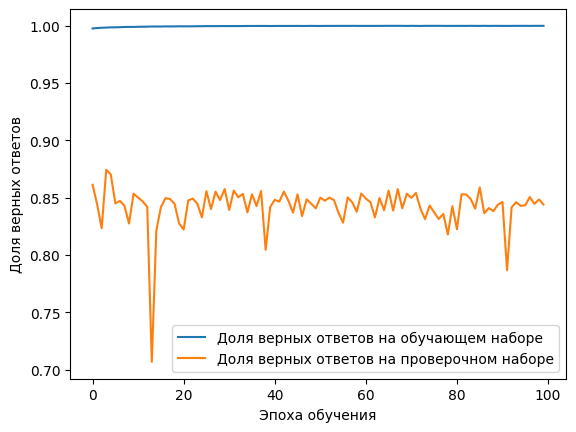

In [90]:
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Распознаем данные из тестового набора

In [113]:
y_predit = model.predict(x_test)

3125/3125 [==============================] - 4s 1ms/step


In [114]:
y_predit[:5]

array([[0.9999999 ],
       [0.06448419],
       [1.        ],
       [0.93730813],
       [1.        ]], dtype=float32)

Округляем до 0 или 1

In [116]:
y_predit = y_predit.round()

In [117]:
y_predit

array([[1.],
       [0.],
       [1.],
       ...,
       [1.],
       [0.],
       [0.]], dtype=float32)

In [118]:
accuracy_score(y_test, y_predit)

0.84985